## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import datasets, metrics, svm

from collections import Counter
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

print(np.__version__)



2.2.4


**QUESTION:** Load dataset and display some lines of the csv file.

In [85]:
data = pd.read_csv("ai4i2020.csv")
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


We can see that the input data are :
- UDI
- Product ID
- Product type
- Air temperature
- Process temperature
- Rotational speed
- Torque
- Tool wear
- Machine failure

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

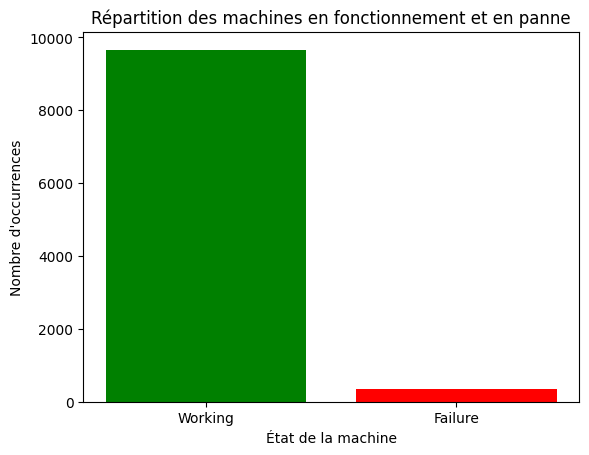

Nombre d'occurrences de chaque état :
 Machine failure
0    9661
1     339
Name: count, dtype: int64
Pourcentage de machines en panne : 3.39%


In [86]:
counts_failure = data['Machine failure'].value_counts()

plt.bar(counts_failure.index, counts_failure.values, color=["green", "red"])

plt.xticks([0, 1], ["Working", "Failure"])  # Noms des catégories
plt.xlabel("État de la machine")
plt.ylabel("Nombre d'occurrences")
plt.title("Répartition des machines en fonctionnement et en panne")

plt.show()
print("Nombre d'occurrences de chaque état :\n", counts_failure)

print("Pourcentage de machines en panne : {:.2f}%".format(counts_failure[1] / counts_failure.sum() * 100))

**ANALYSIS QUESTION:** What do you observe?


Lorsque nous affichons les données nous mettons les RNF dans la colonne Working. En effet lorsqu'un RNF a lieu cela n'est pas répertorié comme une 'Machine Failure'. On les retrouve donc dans la colonne Working ce qui est cohérent puisque ces problèmes sont aléatoires et que l'objectif de notre modèle est de prévoir les problèmes sur les machines. Nous ne pouvons pas prévoir les problèmes aléatoires, il est donc cohérent que nous ne comptabilisions pas ces Fail aléatoires comme des Fails puisque nous ne souhaitons pas les prendre en compte dans l'apprentissage.

Au final nous voyons que nous avons peu de données pour les Failure (uniquement 339). Cela va donc compliquer l'apprentissage.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Nous avons peu de données répertoriant des Fails dans notre Dataset. Notre objectif est d'identifier les pannes sur la machine et nous avons seulement 339 réferencements de pannes. Ainsi, même si notre Dataset est de grande taille il n'est pas très complet car 96,51% des données correspondent à un fonctionnement normal.

Notre apprentissage risque donc d'être peu précis à cause d'une faible quantité de données.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

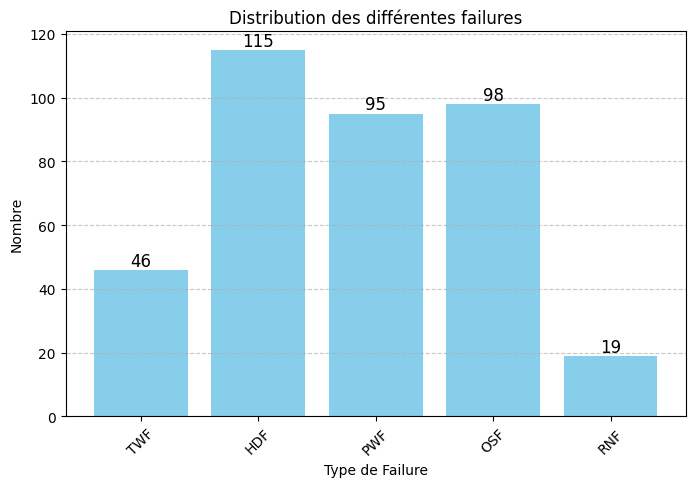

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv("ai4i2020.csv")

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = dataset[failure_types].sum()

plt.figure(figsize=(8, 5))
bars = plt.bar(failure_counts.index, failure_counts.values, color='skyblue')

# value above each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             int(bar.get_height()), ha='center', va='bottom', fontsize=12)

plt.xlabel("Type de Failure")
plt.ylabel("Nombre")
plt.title("Distribution des différentes failures")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**ANALYSIS QUESTION:** What do you observe?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

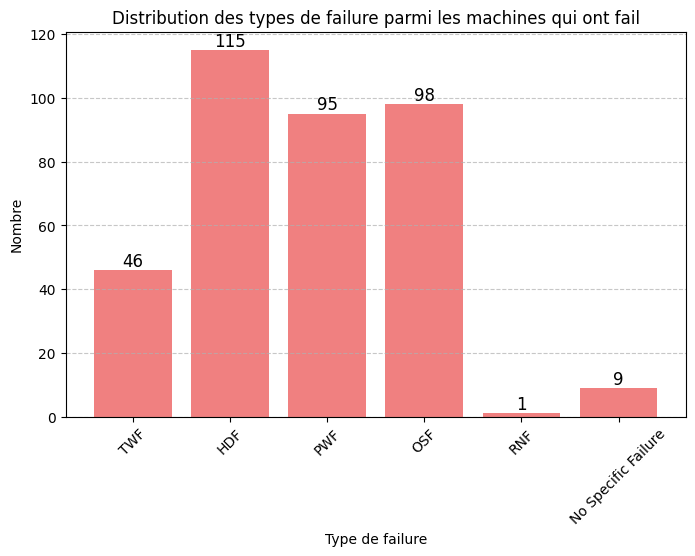

In [88]:
dataset = pd.read_csv("ai4i2020.csv")
failed_machines = dataset[dataset["Machine failure"] == 1]
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]
failure_counts = failed_machines[failure_types].sum()
no_specific_failure = (failed_machines[failure_types].sum(axis=1) == 0).sum()

failure_counts["No Specific Failure"] = no_specific_failure

plt.figure(figsize=(8, 5))
bars = plt.bar(failure_counts.index, failure_counts.values, color='lightcoral')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             int(bar.get_height()), ha='center', va='bottom', fontsize=12)

plt.xlabel("Type de failure")
plt.ylabel("Nombre")
plt.title("Distribution des types de failure parmi les machines qui ont fail")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


**ANALYSIS QUESTION:** What do you obsrve compared to the previous question ? What can you conclude?

On pense que la seule donnée RNF est sûrement une erreur dans le dataset, puisque RNF et TWF sont à 1. Cela veut dire que la machine failure est contabilisée 2 fois, en tant que random et en tant que failure définie. Cela est contradictoire.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [89]:
print(dataset.dtypes)


UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

**Outputs**
Nous voulons prévoir si une machine va fail et son type de failure donc on a les outputs suivants :

- machine failure (0 ou 1)
- le type de failure (TWF, HDF, PWF, OSF, RNF qui sont à 0 ou 1)

**Inputs**
Le model doit utiliser les conditions dans lesquelles est la machine, et ses paramètres pour prédire la failure. Donc les inputs sont :

- Air temperature
- Process temperature
- Rotational speed 
- Torque 
- Tool wear 

On ne prend pas UDI, product ID et Type puisqu'ils ne renseigne aucune donnée utilisable pour prédire la failure.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

On ne prend pas comme entrée le type de produit puisque nous considérons que cela n'influence pas la machine. Il serait tout de même intéressant de tester un modèle prenant en compte ce paramètre.

In [90]:
dataset['No Failure'] = 1 - dataset["Machine failure"]
#La première classe correspondra à "pas d'erreur"

X = dataset[["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]].to_numpy()
Y = dataset[["No Failure", "TWF", "HDF", "PWF", "OSF"]].to_numpy()
#La première classe correspondra à "pas d'erreur", les autres sont les erreurs possibles sans compter "RNF"

# Normalisation des données ?
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
X_scaled = X #On ne normalise pas
# Reshape des données pour les rendre compatibles avec Conv1D
#X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1]))

# Division en jeu d'entraînement (80%) et de test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
print(X_train.shape)
# Afficher le nombre d'éléments dans chaque ensemble
print(f"Nombre d'éléments dans X_train : {X_train.shape}")
print(f"Nombre d'éléments dans Y_train : {Y_train.shape}")
print(f"Nombre d'éléments dans X_test : {X_test.shape}")
print(f"Nombre d'éléments dans Y_test : {Y_test.shape}")

(8000, 5)
Nombre d'éléments dans X_train : (8000, 5)
Nombre d'éléments dans Y_train : (8000, 5)
Nombre d'éléments dans X_test : (2000, 5)
Nombre d'éléments dans Y_test : (2000, 5)


**QUESTION** Code below the model architecture

Nous mettons en place un réseau de neurone MLP.

In [91]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))  # Suppression de la dimension supplémentaire
x = tf.keras.layers.Dense(32, activation='relu')(inputs)  # Plus de neurones dans la première couche cachée
x = tf.keras.layers.Dense(64, activation='relu')(inputs) 
x = tf.keras.layers.Dense(32, activation='relu')(x)  # Ajout d'une deuxième couche cachée
outputs = tf.keras.layers.Dense(Y_train.shape[1], activation='softmax')(x)  # Couche de sortie pour 5 classes
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="improved_mlp_model")

my_mlp_model.summary()

# Compilation du modèle
my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "improved_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629 (10.27 KB)

 Trainable params: 2,629 (10.27 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

In [92]:
nb_epochs=20
batch_size=32

training_history = my_mlp_model.fit(X_train,Y_train,
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# Évaluation du modèle sur les données de test
test_loss, test_acc = my_mlp_model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.8924 - loss: 11.3761
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.9424 - loss: 0.9688
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.9534 - loss: 0.4954
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.9450 - loss: 1.8889
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.9485 - loss: 0.4411
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.9485 - loss: 0.6922
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.9518 - loss: 0.3918
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9512 - loss: 0.7863  
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.9532 - loss: 0.4748
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9433 - loss: 0.6304  
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.9518 - loss: 0.5864
Epoch 12/20
250/250 ━━━━━━━━━

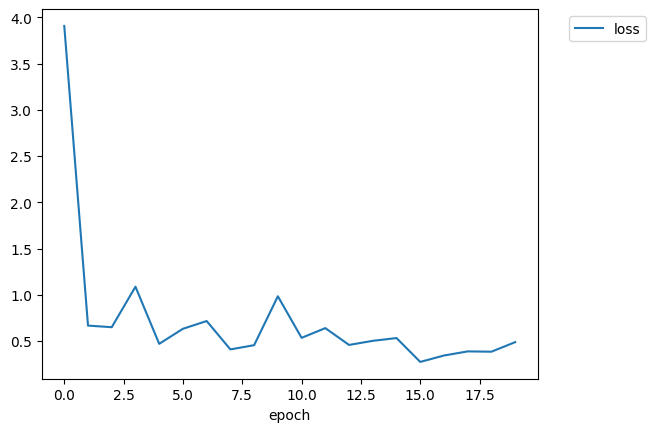

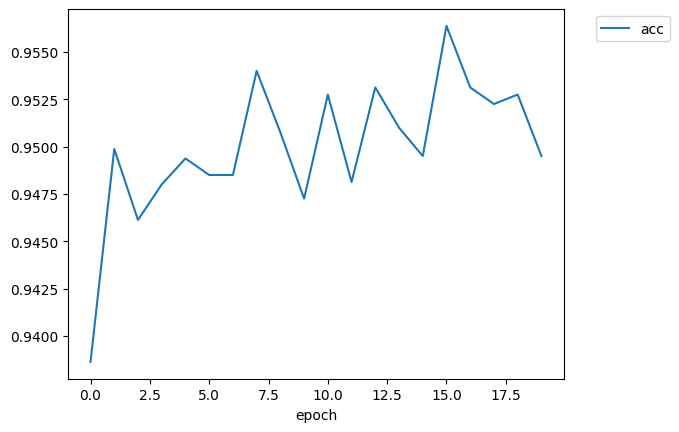

Final Accuracy on test set: 0.9704999923706055


In [93]:
def display_training_curves(training_history):
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

display_training_curves(training_history)

print("Final Accuracy on test set:", test_acc)


    **QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
[[1.0000000e+00 8.3102680e-09 4.7199563e-08 3.8031858e-21 6.5034329e-14]
 [9.9998057e-01 2.1312033e-15 1.9443829e-05 6.5973930e-19 2.0014143e-17]
 [9.9999940e-01 2.6236969e-14 5.8386263e-07 2.0864487e-19 1.8901708e-18]
 ...
 [9.9742496e-01 3.0137609e-21 2.5750978e-03 5.0644312e-16 1.6079469e-20]
 [1.0000000e+00 4.1935872e-21 8.7568751e-28 6.9006848e-17 0.0000000e+00]
 [9.9606651e-01 4.1979537e-21 3.9335219e-03 2.7398914e-16 4.0348103e-20]]
Classification report for classifier my_mlp_model:
              precision    recall  f1-score   support

  No Failure       0.97      1.00      0.99      1941
         TWF       0.00      0.00      0.00        11
         HDF       0.00      0.00      0.00        17
         PWF       0.00      0.00      0.00        18
         OSF       0.00      0.00      0.00        13

   micro avg       0.97      0.97      0.97      2000
   macro avg       0.19      0.20      0.20      2000
weighted avg       0.94      0

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


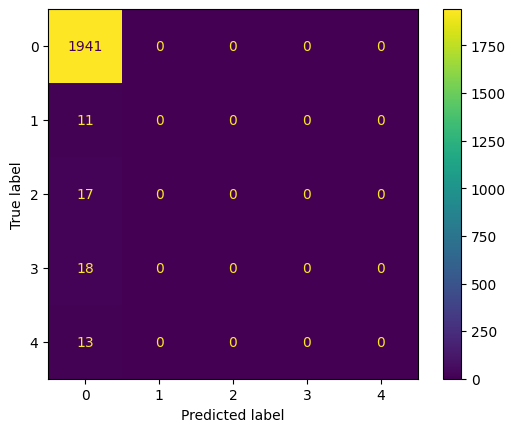

In [94]:
predictions = my_mlp_model.predict(X_test)
print(predictions)
predictions_bin = np.zeros_like(predictions)
predictions_bin[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1


Y_test_bin  = np.zeros_like(Y_test)
Y_test_bin[np.arange(Y_test.shape[0]), np.argmax(Y_test, axis=1)] = 1

class_names = ["No Failure", "TWF", "HDF", "PWF", "OSF"]

print(
    f"Classification report for classifier my_mlp_model:\n"
    f"{classification_report(Y_test_bin, predictions_bin, target_names=class_names)}\n"
)

cm = confusion_matrix(Y_test_bin.argmax(axis=1), predictions_bin.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

On voit bien sur la matrice de confusion que le modèle fait des bonnes prédictions pour la classe 0 mais pas pour les autres.
En effet, la classe 0 correspond à "No Failure" et pour rappel, nous avions trouvé les résultats suivants dans la première partie de ce rapport : 
Nombre d'occurrences de chaque état :
| Machine failure | Count |
|----------------|-------|
| 0              | 9661  |
| 1              | 339   |


On voit donc que dans le Dataset complet, 97% des données correspondent à une absence de défaut.

Ainsi, lorsque le modèle apprend il catégorise en permancence dans la classe 0 ce qui fait que l'accuracy est de 97% comme on peut le voir sur les graphiques plus haut lors de l'apprentissage.

Il est donc nécessaire de modifier le dataset pour que les données de la classe 0 soient en proportion similaires à celles des autres classes.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
# Normalisation des données
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)


# Convertir les étiquettes multilabel en une seule étiquette par échantillon
Y_single_label = np.array([np.argmax(row) for row in Y])
print(Counter(Y_single_label))  # Afficher la distribution originale des classes

# Afficher la distribution originale des classes
print('Original dataset shape:', Counter(Y_single_label))

# Appliquer SMOTE pour équilibrer les classes
sm = SMOTE(random_state=42)
#Si on veut appliquer uniquement SMOTE on remplace Y_res par Y_single_label
X_res, Y_res = sm.fit_resample(X_scaled, Y_single_label)

# Afficher la distribution des classes après rééchantillonnage
print('Resampled dataset shape with SMOTE:', Counter(Y_res))

#A commenter si on veut appliquer uniquement SMOTE
# Appliquer RandomUnderSampler pour équilibrer les classes avec sampling_strategy='auto'
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res, Y_res_single_label = rus.fit_resample(X_res, Y_res)

# Afficher la distribution des classes après rééchantillonnage
print('Resampled dataset shape:', Counter(Y_res_single_label))

# Convertir les étiquettes rééchantillonnées en format multilabel (one-hot encoding)
Y_res_multilabel = np.zeros((Y_res_single_label.size, Y.shape[1]))
Y_res_multilabel[np.arange(Y_res_single_label.size), Y_res_single_label] = 1
#Attention, avec cette version si une sample est 0 1 1 0 0 elle sera mise dans la classe 1 et la classe 2


# Diviser les données rééchantillonnées en ensembles d'entraînement et de test
X_train_SMOTE, X_test_SMOTE, Y_train_SMOTE, Y_test_SMOTE = train_test_split(X_res, Y_res_multilabel, test_size=0.2, random_state=42)

# Afficher les éléments de Y_test dont le premier élément est 1
#Seulement pour des tests
Y_test_filtered = Y_test_SMOTE[Y_test_SMOTE[:, 1] == 1]
print(Y_test_filtered)

# Afficher le nombre d'éléments dans chaque ensemble
print(f"Nombre d'éléments dans X_train : {X_train_SMOTE.shape}")
print(f"Nombre d'éléments dans Y_train : {Y_train_SMOTE.shape}")
print(f"Nombre d'éléments dans X_test : {X_test_SMOTE.shape}")
print(f"Nombre d'éléments dans Y_test : {Y_test_SMOTE.shape}")

Counter({np.int64(0): 9670, np.int64(2): 115, np.int64(3): 91, np.int64(4): 78, np.int64(1): 46})
Original dataset shape: Counter({np.int64(0): 9670, np.int64(2): 115, np.int64(3): 91, np.int64(4): 78, np.int64(1): 46})
Resampled dataset shape with SMOTE: Counter({np.int64(0): 9670, np.int64(3): 9670, np.int64(1): 9670, np.int64(4): 9670, np.int64(2): 9670})
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Nombre d'éléments dans X_train : (38680, 5)
Nombre d'éléments dans Y_train : (38680, 5)
Nombre d'éléments dans X_test : (9670, 5)
Nombre d'éléments dans Y_test : (9670, 5)


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

TODO : Change

Nous ne souhaitions pas utiliser la méthode d'Undersampling puisque nous avons déjà peu d'échantillon présentant des failures. Cela aurait fait perdre beaucoup d'information et notre dataset aurait été très petit.

Nous avons donc testé la méthode SMOTE, qui va permettre de générer des échantillons pour les classes en minorité. Ainsi, on enrichira notre dataset au lieu de l'appauvrir comme la technique précédente.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [ ]:
inputs = tf.keras.Input(shape=(X_train_SMOTE.shape[1],))  # Première couche de la taille des données d'entrée (5)
x = tf.keras.layers.Dense(32, activation='relu')(inputs)  # 3 couches cachées
x = tf.keras.layers.Dense(64, activation='relu')(inputs) 
x = tf.keras.layers.Dense(32, activation='relu')(x) 
outputs = tf.keras.layers.Dense(Y_train_SMOTE.shape[1], activation='softmax')(x)  # Couche de sortie pour 5 classes
improved_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="improved_mlp_model")

improved_mlp_model.summary()

# Compilation du modèle
improved_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "improved_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629 (10.27 KB)

 Trainable params: 2,629 (10.27 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 2s 901us/step - accuracy: 0.4756 - loss: 13.9986
Epoch 2/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.7267 - loss: 0.9233
Epoch 3/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7696 - loss: 0.8153
Epoch 4/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.7849 - loss: 0.7572
Epoch 5/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.7928 - loss: 0.7609
Epoch 6/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.8134 - loss: 0.6905
Epoch 7/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.8346 - loss: 0.5814
Epoch 8/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.8267 - loss: 0.6110
Epoch 9/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.8313 - loss: 0.6000
Epoch 10/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - accuracy: 0.8438 - loss: 0.5335
Epoch 11/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.8612 - loss: 0.4565
Epoch 12/

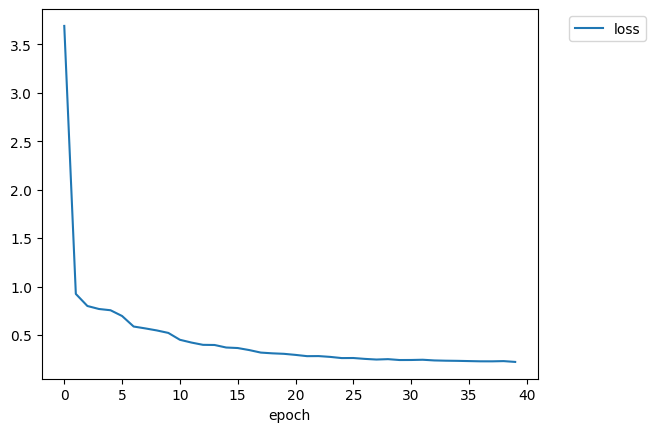

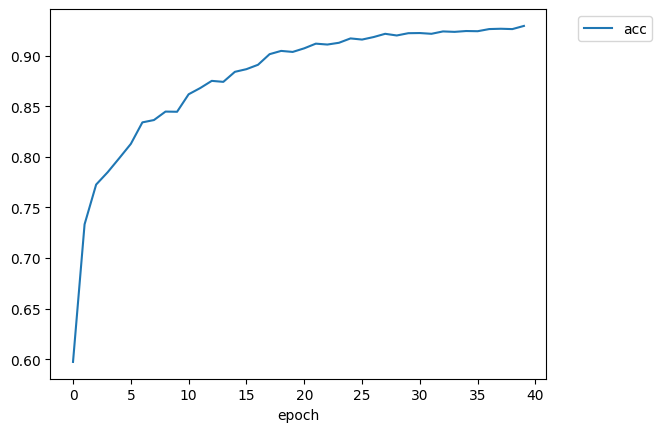

Final Accuracy on test set: 0.9271975159645081


In [121]:
nb_epochs=40
batch_size=32

training_history = improved_mlp_model.fit(X_train_SMOTE,Y_train_SMOTE,
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# Évaluation du modèle sur les données de test
test_loss, test_acc = improved_mlp_model.evaluate(X_test_SMOTE, Y_test_SMOTE)
print(f"Test accuracy: {test_acc}")

display_training_curves(training_history)
print("Final Accuracy on test set:", test_acc)

**QUESTION** Plot the confusion matrix and the classification report

303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
Classification report for classifier improved_mlp_model:
              precision    recall  f1-score   support

  No Failure       0.99      0.81      0.89      1959
         TWF       0.93      0.91      0.92      1858
         HDF       0.86      0.97      0.91      1956
         PWF       0.99      0.98      0.98      1966
         OSF       0.89      0.97      0.93      1931

   micro avg       0.93      0.93      0.93      9670
   macro avg       0.93      0.93      0.93      9670
weighted avg       0.93      0.93      0.93      9670
 samples avg       0.93      0.93      0.93      9670




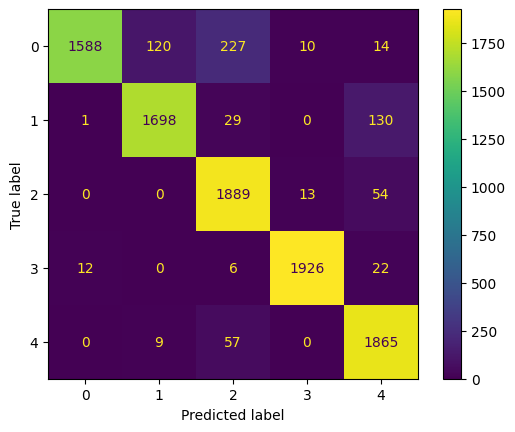

In [122]:
predictions = improved_mlp_model.predict(X_test_SMOTE)

predictions_bin = np.zeros_like(predictions)
predictions_bin[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1


Y_test_bin  = np.zeros_like(Y_test_SMOTE)
Y_test_bin[np.arange(Y_test_SMOTE.shape[0]), np.argmax(Y_test_SMOTE, axis=1)] = 1


print(
    f"Classification report for classifier improved_mlp_model:\n"
    f"{classification_report(Y_test_bin, predictions_bin, target_names=class_names)}\n"
)

cm = confusion_matrix(Y_test_bin.argmax(axis=1), predictions_bin.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

**Exportation of the model :**

In [123]:
'''improved_mlp_model.save('./saved_models/improved_mlp_model.h5', save_format='h5')

converter = tf.lite.TFLiteConverter.from_keras_model(improved_mlp_model)
tflite_model = converter.convert()
with open('./saved_models/improved_mlp_model.tflite', 'wb') as f:
    f.write(tflite_model)
'''

Y_test_single_label = np.array([np.argmax(row) for row in Y_test_SMOTE])

#Les tableaux de données exportées sont ceux avec le SMOTE correspondant aux données avec des classes équilibrées TODO
np.savetxt("./saved_data/X_test.csv", X_test_SMOTE.reshape(X_test_SMOTE.shape[0], -1), delimiter=",", fmt="%.6f")  # On exporte en flottants
np.savetxt("./saved_data/Y_test.csv", Y_test_single_label.reshape(Y_test_single_label.shape[0], -1), delimiter=",", fmt="%d")  # Save as .csv
np.save("./saved_data/X_test.npy", X_test_SMOTE)  # Save as .npy
np.save("./saved_data/Y_test.npy", Y_test_single_label)  # Save as .npy

In [124]:
def test_single_input(model, input_data, class_names):
    # Reshape the input data to match the model's expected input shape
    input_data = np.array(input_data).reshape(1, -1)
    
    # Make a prediction
    prediction = model.predict(input_data)
    # Convert the prediction to a binary format
    prediction_bin = np.zeros_like(prediction)
    prediction_bin[np.arange(prediction.shape[0]), np.argmax(prediction, axis=1)] = 1
    print(prediction_bin)

    # Get the predicted class
    predicted_class = class_names[np.argmax(prediction)]
    
    print(f"Input data: {input_data}")
    print(f"Predicted class: {predicted_class}")

# Example input data (replace with actual input data)
index = np.where(Y[:, 1] == 1)[0][5]  # Trouver le premier index où TWF est 1

example_input = X[index]

# Test the model on the example input
test_single_input(improved_mlp_model, example_input, class_names)
print("Expected result :", Y[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[1. 0. 0. 0. 0.]]
Input data: [[ 298.4  308.  1416.    38.2  198. ]]
Predicted class: No Failure
Expected result : [0 1 0 0 0]
